# Imports

In [1]:
# from factor_analyzer import (ConfirmatoryFactorAnalyzer, ModelSpecificationParser)    

# model_dict = {"F1": ["V1", "V2", "V3", "V4"], "F2": ["V5", "V6", "V7", "V8"]}

# model_spec = ModelSpecificationParser.parse_model_specification_from_dict(df, model_dict)

# cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 

# cfa.fit(df.values) 

# cfa.loadings_ 

In [2]:
import numpy as np
import os
import pandas as pd
import plotnine as gg
gg.theme_set(gg.theme_classic)
import sklearn.decomposition as skdec

In [114]:
from Functions import get_ages_cols, get_param_names, get_category_dict, get_category_from_feature, name_from_index, bool_from_index, get_quantile_groups

## Directories etc.

In [4]:
data_save_path = "C:/Users/maria/MEGAsync/SLCNdata/Meta/all_data"
plot_save_path = "C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots"
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# Get data

In [5]:
all_data = pd.read_csv(os.path.join(data_save_path, 'all_data.csv'), index_col=0)
all_data_z = pd.read_csv(os.path.join(data_save_path, 'all_data_z.csv'), index_col=0)
all_data_long = pd.read_csv(os.path.join(data_save_path, 'all_data_long.csv'), index_col=0)
all_data_long_z = pd.read_csv(os.path.join(data_save_path, 'all_data_long_z.csv'), index_col=0)

In [6]:
ages_dir = "C:/Users/maria/MEGAsync/SLCNdata/SLCNinfo2.csv"
ages = pd.read_csv(os.path.join(ages_dir))

In [7]:
ages_cols = get_ages_cols()
param_names = get_param_names()
category_dict = get_category_dict()

In [8]:
n_comp = 9  # How many PCA components?
feature_pc_scalar = 5  # How much should we exagerate the differences between positive and negative directions in pc in features?

# Dimensionality reduction (PCA)

In [9]:
# Run PCA
def run_pca(pca_dat):
    
    pca = skdec.PCA(n_components=pca_dat.shape[1])
    # pca = KernelPCA(n_components=z_dat.shape[1])
    fit = pca.fit_transform(pca_dat)
    
    return pca, fit

# Run PCA on all data
ids_all = all_data_z.drop(columns=ages_cols[1:]).dropna().ID
pca_dat_all = all_data_z.drop(columns=ages_cols).dropna()
pca_all, fit_all = run_pca(pca_dat_all)

# Run PCA on behavior only
param_cols = []
for col in all_data_z.columns:
    for param_name in param_names:
        if param_name in col:
            param_cols += [col]

ids_beh = all_data_z.drop(columns=ages_cols[1:] + param_cols).dropna().ID
pca_dat_beh = all_data_z.drop(columns=ages_cols + param_cols).dropna()
pca_beh, fit_beh = run_pca(pca_dat_beh)

# Run PCA on params only
ids_par = all_data_z[param_cols + ['ID']].dropna().ID
pca_dat_par = all_data_z[param_cols].dropna()
pca_par, fit_par = run_pca(pca_dat_par)

Explained variance at 20 components: 83.3%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceAll.png


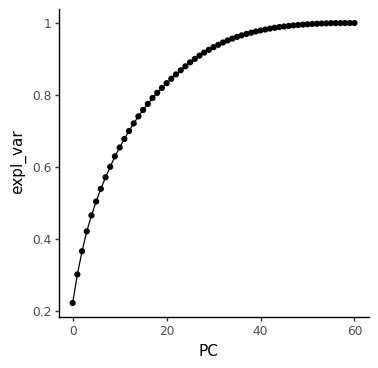

<ggplot: (135367948990)>
Explained variance at 20 components: 88.0%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVarianceBeh.png


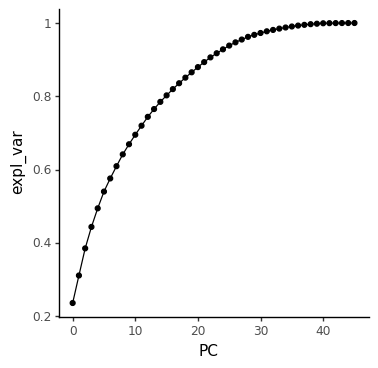

<ggplot: (135369040704)>
Explained variance at 20 components: 100.0%.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCAExplainedVariancePar.png


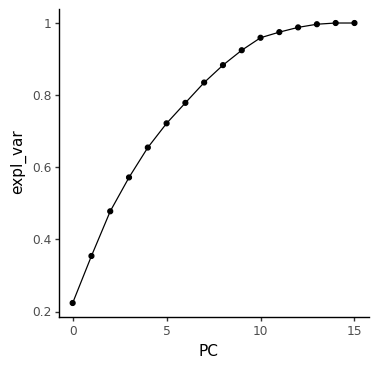

<ggplot: (135369029419)>


In [10]:
# Plot explained variance
def plot_expl_var(pca_dat, pca, name):
    
    n_comp = 20
    expl_var_dat = pd.DataFrame({'PC': range(pca_dat.shape[1]), 'expl_var': np.cumsum(pca.explained_variance_ratio_)})
    expl_var_at_n_comp = list(expl_var_dat[expl_var_dat.PC <= n_comp].expl_var)[-1]
    print("Explained variance at {} components: {}%.".format(n_comp, round(100 * expl_var_at_n_comp, 1)))

    g = (gg.ggplot(expl_var_dat, gg.aes('PC', 'expl_var'))
         + gg.geom_point()
         + gg.geom_line()
    #      + gg.geom_hline(yintercept=1, linetype='dashed')
    #      + gg.geom_hline(yintercept=expl_var_at_n_comp, linetype='dotted')
    #      + gg.geom_vline(xintercept=n_comp, linetype='dotted')
    )
    g.save(os.path.join(plot_save_path, '3_PCAExplainedVariance{}.png'.format(name)))
    print(g)
    
# Explained variance all behaviors
gg.options.figure_size = (4, 4)
plot_expl_var(pca_dat_all, pca_all, 'All')
plot_expl_var(pca_dat_beh, pca_beh, 'Beh')
plot_expl_var(pca_dat_par, pca_par, 'Par')

In [11]:
def create_fit_pd(fit, pca_dat, ids, ages_sub, n_comp=n_comp):
    
    # fit_pd
    fit_pd = pd.DataFrame(fit,
                          columns=['pc{}'.format(i) for i in range(pca_dat.shape[1])],
                          index=ids)
    fit_pd = fit_pd.reset_index()
    fit_pd = fit_pd.merge(ages_sub)
    
    # fit_long
    fit_pd_long = fit_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS'])

    return fit_pd, fit_pd_long

# Create fit_pd's
ages_sub = ages[['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS']]
fit_pd_all, fit_pd_long_all = create_fit_pd(fit_all, pca_dat_all, ids_all, ages_sub)
fit_pd_beh, fit_pd_long_beh = create_fit_pd(fit_beh, pca_dat_beh, ids_beh, ages_sub)
fit_pd_par, fit_pd_long_par = create_fit_pd(fit_par, pca_dat_par, ids_par, ages_sub)

# Save as csv
fit_pd_all.to_csv(os.path.join(data_save_path, 'fit_pd_all.csv'))
fit_pd_beh.to_csv(os.path.join(data_save_path, 'fit_pd_beh.csv'))
fit_pd_par.to_csv(os.path.join(data_save_path, 'fit_pd_par.csv'))

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_PDS_All.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in 

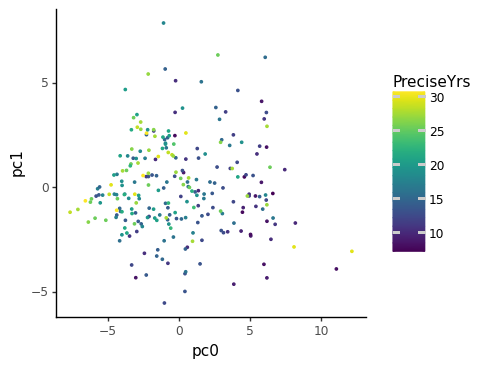

<ggplot: (135369160162)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_Beh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_Beh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_PDS_Beh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in 

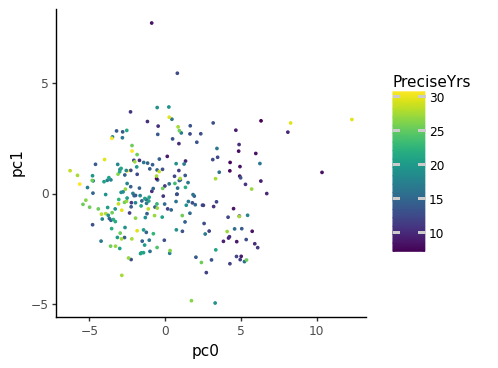

<ggplot: (135369292912)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_Age_Par.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc2Pc3_Age_Par.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_Pc0Pc1_PDS_Par.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 4 x 4 in 

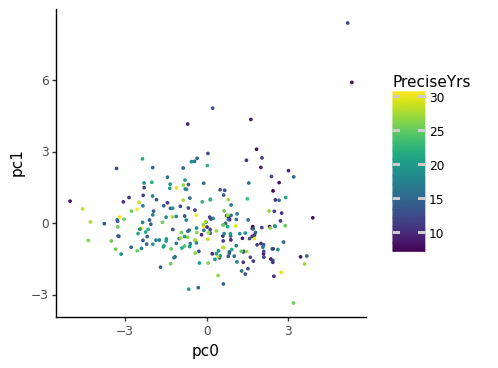

<ggplot: (135369277703)>


In [12]:
# Age in PC space
def plot_age_in_pc_space(fit_pd, name):
    
    g1 = (gg.ggplot(fit_pd, gg.aes('pc0', 'pc1', color='PreciseYrs'))
     + gg.geom_point(size=0.5)
    )
    g1.save(os.path.join(plot_save_path, '3_Pc0Pc1_Age_{}.png'.format(name)))

    g2 = g1 + gg.aes('pc2', 'pc3')
    g2.save(os.path.join(plot_save_path, '3_Pc2Pc3_Age_{}.png'.format(name)))
    
    g3 = g1 + gg.aes(color='PDS')
    g3.save(os.path.join(plot_save_path, '3_Pc0Pc1_PDS_{}.png'.format(name)))

    g4 = g1 + gg.aes(color='meanT')
    g4.save(os.path.join(plot_save_path, '3_Pc0Pc1_T_{}.png'.format(name)))
    
    print(g1)

# Run on all measures
plot_age_in_pc_space(fit_pd_all, 'All')
plot_age_in_pc_space(fit_pd_beh, 'Beh')
plot_age_in_pc_space(fit_pd_par, 'Par')

In [126]:
fit_pd_long_all['age_group'] = get_quantile_groups(fit_pd_long_all, 'PreciseYrs')[0]
fit_pd_long_all['age_group_'] = pd.Categorical(fit_pd_long_all.age_group.replace({0.25: '08-10', 0.5: '10-13', 0.75: '13-15', 1: '15-17', 2: '2Stud.', 3: '3Adult'}), ordered=True)
fit_pd_long_all

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable,value,age_group,age_group_
0,17,8.657084,18.200751,2.0,NaN,2.50,pc0,6.161400,0.25,08-10
1,18,12.637919,16.157863,2.0,NaN,2.25,pc0,-2.097965,0.50,10-13
2,20,14.543463,17.433768,1.0,120.649667,2.80,pc0,-4.100427,0.75,13-15
3,22,16.490075,22.709959,1.0,147.334443,3.00,pc0,1.769714,1.00,15-17
4,23,11.206023,15.147686,1.0,27.712900,1.00,pc0,0.487362,0.50,10-13
...,...,...,...,...,...,...,...,...,...,...
2218,465,22.333333,NaN,2.0,NaN,NaN,pc8,1.378609,2.00,2Stud.
2219,466,20.083333,NaN,1.0,NaN,NaN,pc8,-1.388593,2.00,2Stud.
2220,467,18.750000,NaN,2.0,NaN,NaN,pc8,0.588971,2.00,2Stud.
2221,468,21.833333,NaN,2.0,NaN,NaN,pc8,-2.293321,2.00,2Stud.


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks

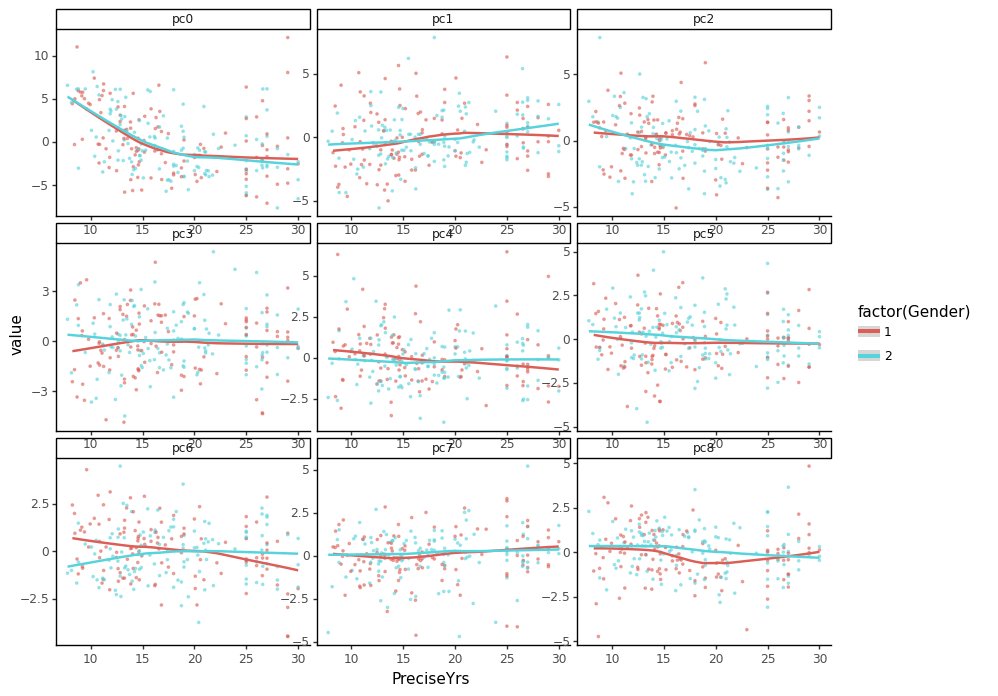

<ggplot: (135372540456)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks\l

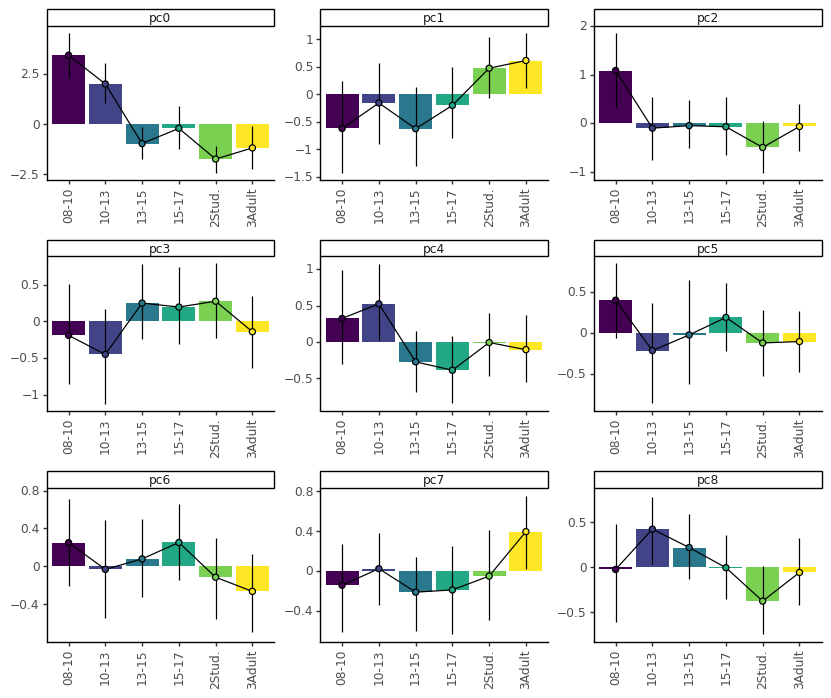

<ggplot: (135369603774)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeGroupAll.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverAgeBeh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate valu

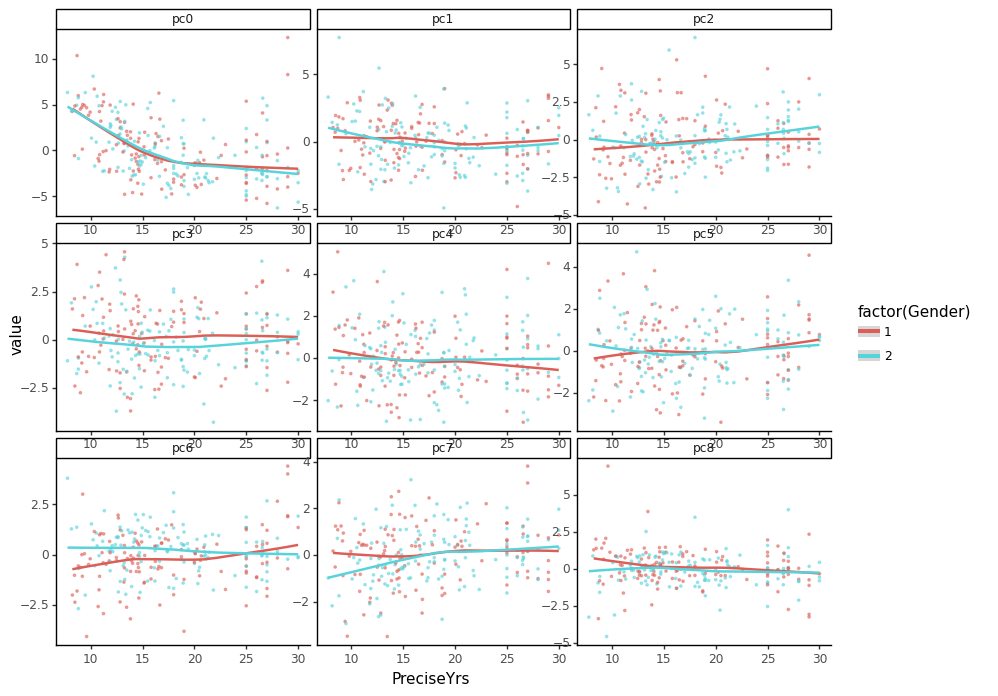

<ggplot: (135376761826)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsOverTBeh.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\facets\facet.py:555: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
C:\Users\maria\Anaconda3\envs\notebooks\l

PlotnineError: "Could not evaluate the 'fill' mapping: 'age_group_' (original error: name 'age_group_' is not defined)"

In [130]:
# PC changes over age
def plot_pcs_over_age(fit_pd_long, name):
    
    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(fit_pd_long, gg.aes('PreciseYrs', 'value', color='factor(Gender)'))
     + gg.geom_point(alpha=0.5, size=0.5)
     + gg.geom_smooth()
     + gg.facet_wrap('~ variable', scales='free')
    )
    g.save(os.path.join(plot_save_path, '3_PcsOverAge{}.png'.format(name)))
    print(g)
    
    g_t = g + gg.aes(x='meanT')
    g_t.save(os.path.join(plot_save_path, '3_PcsOverT{}.png'.format(name)))
    
    g_pds = g + gg.aes(x='PDS')
    g_pds.save(os.path.join(plot_save_path, '3_PcsOverPDS{}.png'.format(name)))
    
    g_group = (
        gg.ggplot(fit_pd_long, gg.aes('age_group_', 'value', group=1, fill='age_group_')) # , fill='factor(Gender)', group='factor(Gender)'
        + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.2))
        + gg.stat_summary(geom='line', position=gg.position_dodge(width=0.2))
        + gg.stat_summary(position=gg.position_dodge(width=0.2))
        + gg.labs(x='', y='', fill='')
        + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
        + gg.theme(subplots_adjust={'hspace': 0.5, 'wspace': 0.2})
        + gg.theme(legend_position='none')
        + gg.facet_wrap('~ variable', scales='free')
    )
    print(g_group)
    g_group.save(os.path.join(plot_save_path, '3_PcsOverAgeGroup{}.png'.format(name)))
    
# Plot all
plot_pcs_over_age(fit_pd_long_all, 'All')
plot_pcs_over_age(fit_pd_long_beh, 'Beh')
plot_pcs_over_age(fit_pd_long_par, 'Par')

In [14]:
# Factor loadings
choice_param_cols = []
update_param_cols = []
for col in all_data.columns:
    if ('beta' in col) or ('epsilon' in col) or ('forget' in col):
        choice_param_cols += [col]
    if 'alpha' in col:
        update_param_cols += [col]

In [15]:
def create_loadings_long(pca, pca_dat, n_comp=n_comp):
    
    loadings = pca.components_[:n_comp].T  # (n_components, n_features)
    loadings_pd = pd.DataFrame(loadings, columns=['pc{}'.format(i) for i in range(n_comp)], index=pca_dat.columns)
    loadings_pd = loadings_pd.reset_index().rename(columns={'index': 'feature'})
    loadings_long = loadings_pd.melt(
        value_vars=['pc{}'.format(i) for i in range(n_comp)],
        id_vars=['feature'])
    
    loadings_long['task'] = loadings_long['feature'].apply(lambda x : x[:2])
    loadings_long['ACC_RT'] = loadings_long['feature'].apply(name_from_index, names=['ACC', 'RT'])
    loadings_long['category'] = get_category_from_feature(loadings_long['feature'], category_dict)
    loadings_long['param_bool'] = loadings_long['feature'].apply(bool_from_index, names=param_cols)
    loadings_long['PC'] = loadings_long['variable'].apply(lambda x : int(x[2:]))
    loadings_long['pc<0>'] = loadings_long['value'].apply(lambda x: 'pc>0' if x > 0 else 'pc<0')

    for param in choice_param_cols:
        loadings_long.loc[loadings_long['feature'] == param, 'category'] = 'choice_param'
    for param in update_param_cols:
        loadings_long.loc[loadings_long['feature'] == param, 'category'] = 'update_param'
    
    return loadings_long, loadings_pd

# All
loadings_long_all, loadings_all = create_loadings_long(pca_all, pca_dat_all)
loadings_long_beh, loadings_beh = create_loadings_long(pca_beh, pca_dat_beh)
loadings_long_par, loadings_par = create_loadings_long(pca_par, pca_dat_par)

In [16]:
# Save as csv
loadings_long_all.to_csv(os.path.join(data_save_path, 'loadings_long_all.csv'))
loadings_long_beh.to_csv(os.path.join(data_save_path, 'loadings_long_beh.csv'))
loadings_long_par.to_csv(os.path.join(data_save_path, 'loadings_long_par.csv'))

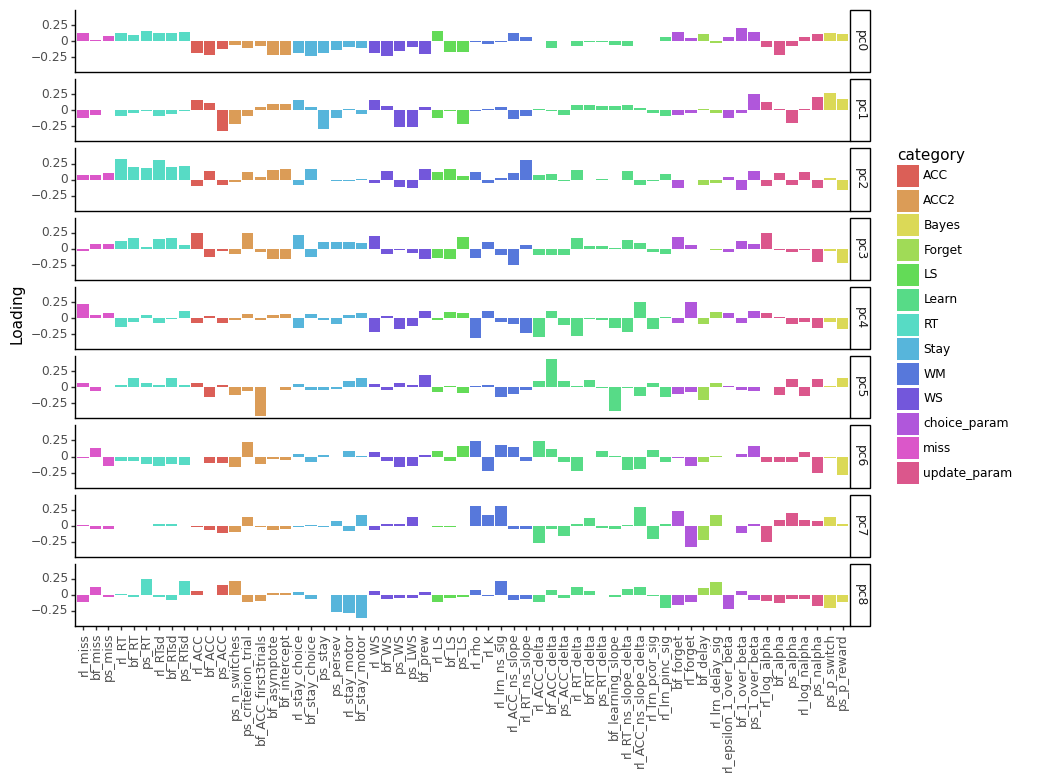

<ggplot: (135369776743)>

In [17]:
x_ticks = []
for features in category_dict.values():
    x_ticks += features
    
g = (gg.ggplot(loadings_long_all, gg.aes('feature', 'value', fill='category'))
     + gg.geom_bar(stat='identity')
     + gg.scale_x_discrete(limits=x_ticks)
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.labs(x='', y='Loading')
     + gg.facet_grid('variable ~')
    )
g

C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All_beh_only.png


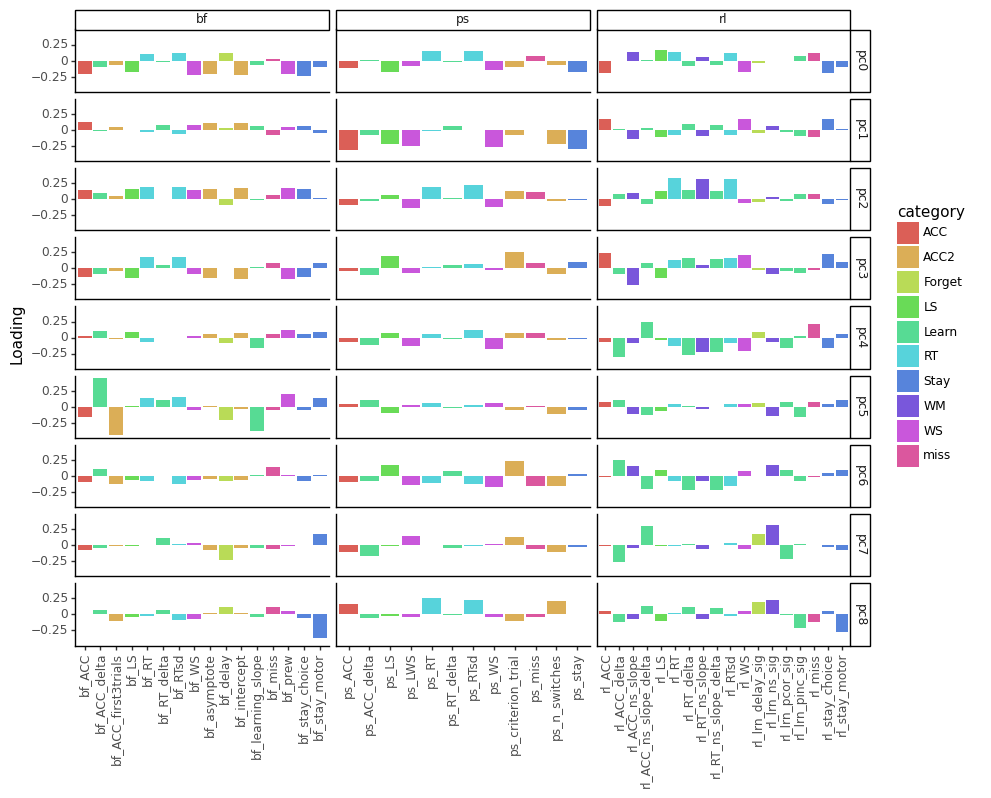

<ggplot: (135369836282)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All_par_only.png


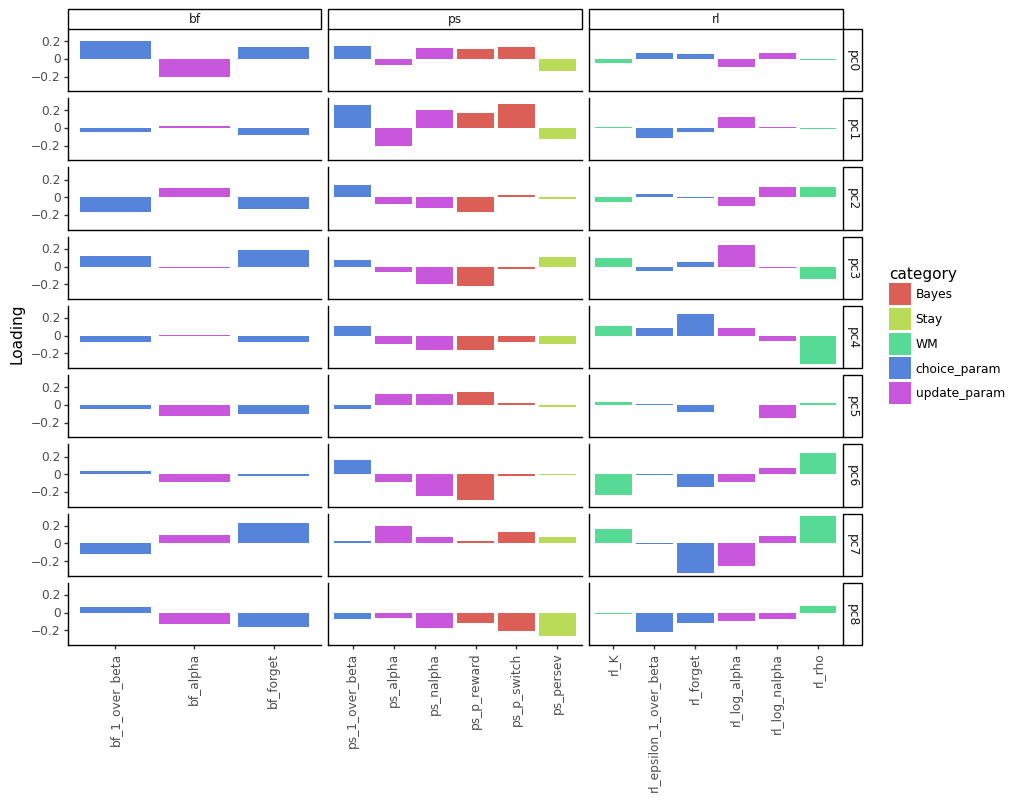

<ggplot: (135372591517)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_All.png


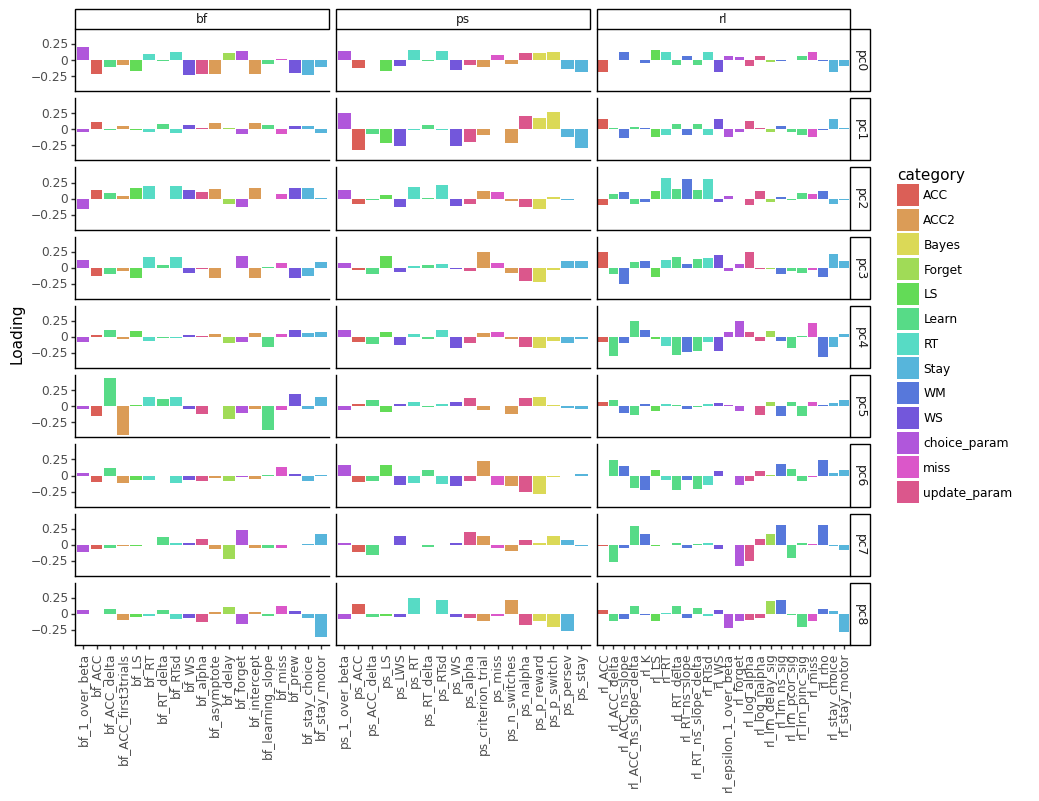

<ggplot: (135369392391)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_Beh.png


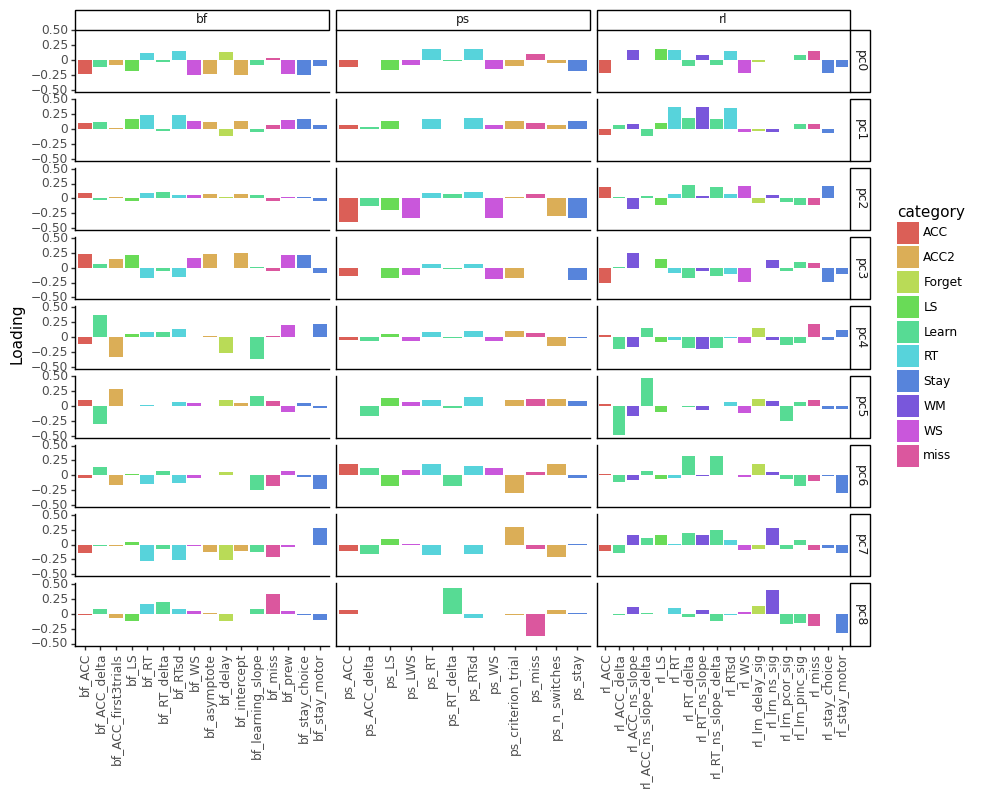

<ggplot: (135371939530)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PCALoadings_Par.png


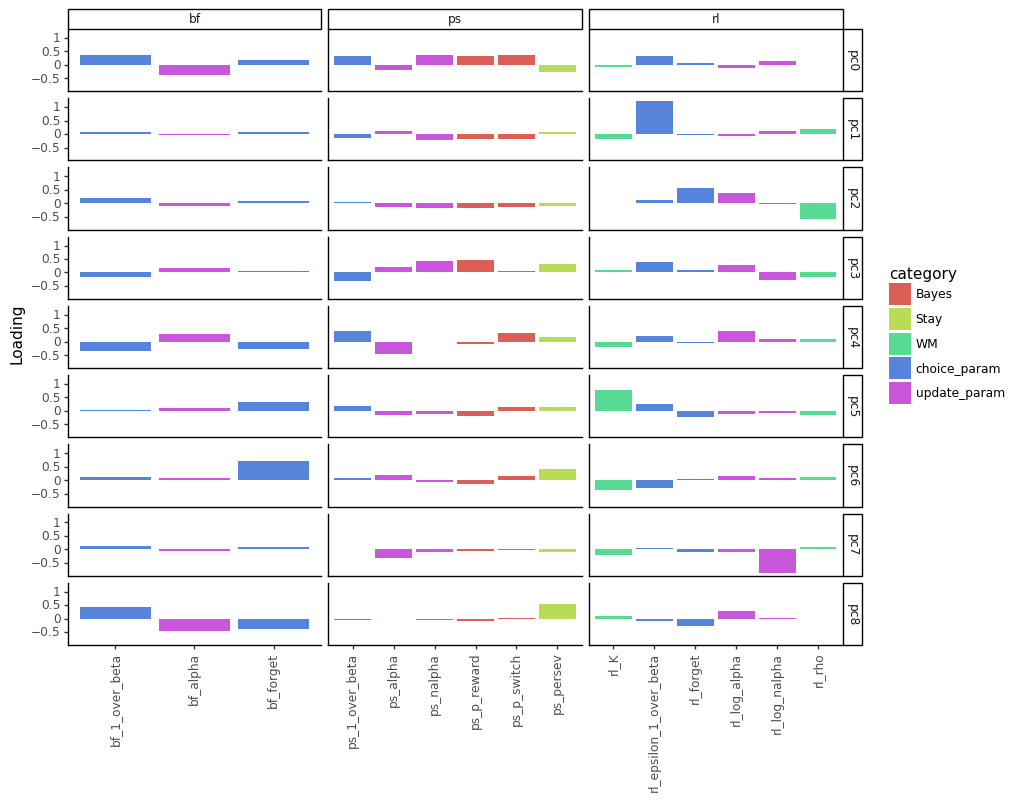

<ggplot: (135369706921)>


In [18]:
def plot_loadings(loadings_long, name, n_comp=n_comp):

    if 'beh_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & np.invert(loadings_long['param_bool'])]
    elif 'par_only' in name:
        sub_dat = loadings_long[(loadings_long['PC'] < n_comp) & (loadings_long['param_bool'])]
    else:
        sub_dat = loadings_long[loadings_long['PC'] < n_comp]

    gg.options.figure_size = (10, 8)
    g = (gg.ggplot(sub_dat, gg.aes('feature', 'value', fill='category'))
         + gg.geom_bar(stat='identity')
         + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
         + gg.facet_grid('variable ~ task', scales='free_x')
         + gg.labs(x='', y='Loading')
    )
    g.save(os.path.join(plot_save_path, '3_PCALoadings_{}.png'.format(name)))
    print(g)
    
# Plot
plot_loadings(loadings_long_all, 'All_beh_only')
plot_loadings(loadings_long_all, 'All_par_only')
plot_loadings(loadings_long_all, 'All')
plot_loadings(loadings_long_beh, 'Beh')
plot_loadings(loadings_long_par, 'Par')

In [19]:
# Plot behavioral and parameter PCs against each other
fit_pd_behpar = pd.merge(fit_pd_long_beh, fit_pd_long_par, on=['ID', 'PreciseYrs', 'BMI', 'Gender', 'meanT', 'PDS'] + ["ID"], suffixes=("_beh", "_par"))
fit_pd_behpar

,ID,PreciseYrs,BMI,Gender,meanT,PDS,variable_beh,value_beh,variable_par,value_par
0,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.933172,pc0,3.911484
1,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.933172,pc1,0.221752
2,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.933172,pc2,-0.324022
3,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.933172,pc3,-0.128305
4,17,8.657084,18.200751,2.0,NaN,2.5,pc0,4.933172,pc4,0.062182
...,...,...,...,...,...,...,...,...,...,...
20002,469,19.000000,NaN,2.0,NaN,NaN,pc8,-1.827086,pc4,-0.666846
20003,469,19.000000,NaN,2.0,NaN,NaN,pc8,-1.827086,pc5,1.818197
20004,469,19.000000,NaN,2.0,NaN,NaN,pc8,-1.827086,pc6,0.648320
20005,469,19.000000,NaN,2.0,NaN,NaN,pc8,-1.827086,pc7,-0.850774


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


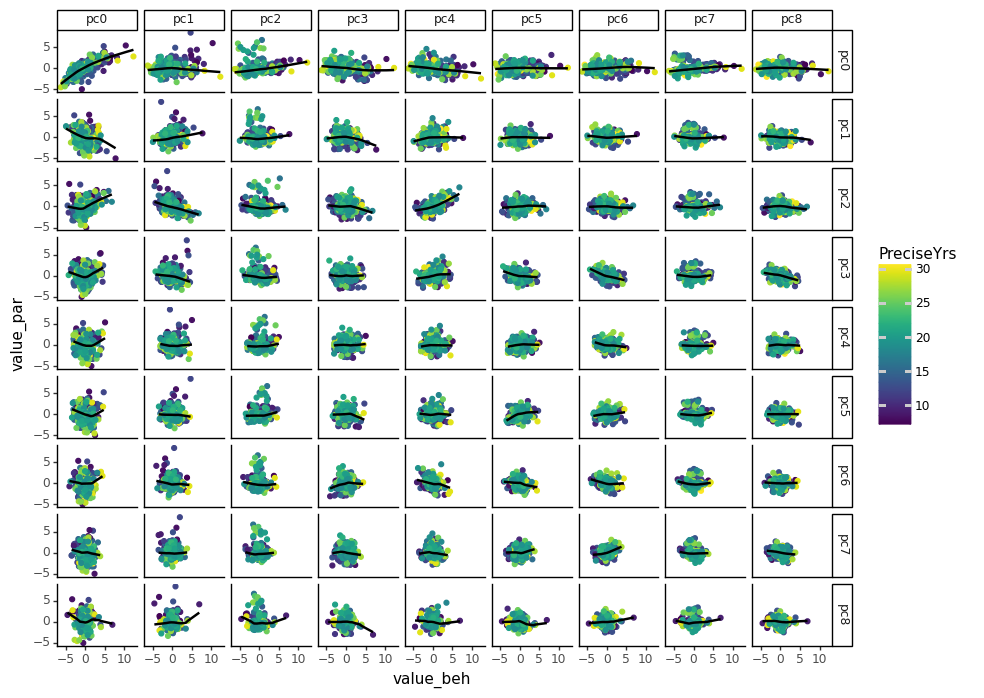

<ggplot: (135372547344)>


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 10 x 8 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_PcsBehVersusPcsPar.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\stats\smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


In [20]:
gg.options.figsize = (20, 20)
g = (gg.ggplot(fit_pd_behpar, gg.aes("value_beh", "value_par", color='PreciseYrs'))
     + gg.geom_point()
     + gg.geom_smooth()
     + gg.facet_grid("variable_beh ~ variable_par")
    )
print(g)
g.save(os.path.join(plot_save_path, '3_PcsBehVersusPcsPar.png'))

## Plot average behavior for big / small values of each PC

In [21]:
feature_means = all_data_long[['feature', 'value']].groupby(['feature']).aggregate('mean').reset_index().rename(columns={'value': 'feature_mean'})
feature_means['category'] = get_category_from_feature(feature_means['feature'], category_dict)
feature_means

,feature,feature_mean,category
0,bf_1_over_beta,0.095496,Beta
1,bf_ACC,0.773526,ACC
2,bf_ACC_delta,0.143443,Learn
3,bf_ACC_first3trials,0.564103,ACC2
4,bf_LS,0.593543,LS
...,...,...,...
56,rl_lrn_pinc_sig,0.542057,Learn
57,rl_miss,0.001194,miss
58,rl_rho,0.840768,WM
59,rl_stay_choice,0.762556,Stay


In [22]:
feature_means_pcs = pd.merge(feature_means, loadings_all)

for pc in ['pc{}'.format(i) for i in range(n_comp)]:
    feature_means_pcs['feature_{}+'.format(pc)] = feature_means_pcs.feature_mean + feature_pc_scalar * feature_means_pcs[pc]
    feature_means_pcs['feature_{}-'.format(pc)] = feature_means_pcs.feature_mean - feature_pc_scalar * feature_means_pcs[pc]

feature_means_pcs

,feature,feature_mean,category,pc0,pc1,pc2,pc3,pc4,pc5,pc6,...,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-
0,bf_1_over_beta,0.095496,Beta,0.198267,-0.041873,-0.165300,0.117744,-0.069578,-0.043878,0.033744,...,-0.252395,0.443386,-0.123893,0.314885,0.264218,-0.073227,-0.475669,0.666660,0.402655,-0.211664
1,bf_ACC,0.773526,ACC,-0.208663,0.118181,0.141230,-0.131245,0.024744,-0.156790,-0.095549,...,0.897246,0.649806,-0.010423,1.557475,0.295783,1.251269,0.413795,1.133257,0.798114,0.748938
2,bf_ACC_delta,0.143443,Learn,-0.101458,-0.015993,0.091591,-0.094348,0.102530,0.441818,0.115239,...,0.656093,-0.369208,2.352531,-2.065646,0.719636,-0.432751,-0.088595,0.375481,0.521188,-0.234302
3,bf_ACC_first3trials,0.564103,ACC2,-0.074503,0.048491,0.045256,-0.047866,-0.027413,-0.439722,-0.124337,...,0.427040,0.701165,-1.634508,2.762713,-0.057582,1.185787,0.484460,0.643746,0.078851,1.049354
4,bf_LS,0.593543,LS,-0.175394,-0.004691,0.160728,-0.151468,0.088577,0.018833,-0.068147,...,1.036430,0.150656,0.687707,0.499379,0.252810,0.934276,0.519648,0.667437,0.370673,0.816413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,rl_lrn_pinc_sig,0.542057,Learn,0.067235,-0.093428,0.086465,-0.074706,0.020286,-0.156896,-0.080495,...,0.643485,0.440630,-0.242422,1.326537,0.139581,0.944534,0.641412,0.442702,-0.497768,1.581883
57,rl_miss,0.001194,miss,0.122658,-0.114275,0.076585,-0.031843,0.217442,0.070653,-0.022156,...,1.088406,-1.086019,0.354457,-0.352069,-0.109588,0.111976,0.039492,-0.037105,-0.548192,0.550579
58,rl_rho,0.840768,WM,-0.015969,-0.009364,0.121733,-0.143143,-0.313397,0.022551,0.244787,...,-0.726219,2.407755,0.953522,0.728013,2.064702,-0.383167,2.368820,-0.687285,1.239338,0.442198
59,rl_stay_choice,0.762556,Stay,-0.187584,0.167223,-0.076710,0.220402,-0.157633,0.047158,0.045781,...,-0.025608,1.550720,0.998345,0.526767,0.991459,0.533654,0.646888,0.878225,1.000279,0.524833


In [23]:
feature_means_pcs_long = feature_means_pcs.melt(id_vars=['feature', 'feature_mean', 'category'])
feature_means_pcs_long['feat_pc'] = feature_means_pcs_long.variable.apply(lambda x : 'feat' if 'feature' in x else 'pc')
feature_means_pcs_long = feature_means_pcs_long.loc[feature_means_pcs_long.feat_pc == 'feat']
feature_means_pcs_long['plus_minus'] = feature_means_pcs_long.variable.apply(lambda x : x[-1:])
feature_means_pcs_long['pc'] = feature_means_pcs_long.variable.apply(lambda x : x[-2])
feature_means_pcs_long['shape'] = feature_means_pcs_long.apply(lambda x : 'o' if x.plus_minus == '+' else ('^' if x.value > x.feature_mean else 'v'), axis=1)
feature_means_pcs_long

,feature,feature_mean,category,variable,value,feat_pc,plus_minus,pc,shape
549,bf_1_over_beta,0.095496,Beta,feature_pc0+,1.086830,feat,+,0,o
550,bf_ACC,0.773526,ACC,feature_pc0+,-0.269790,feat,+,0,o
551,bf_ACC_delta,0.143443,Learn,feature_pc0+,-0.363845,feat,+,0,o
552,bf_ACC_first3trials,0.564103,ACC2,feature_pc0+,0.191588,feat,+,0,o
553,bf_LS,0.593543,LS,feature_pc0+,-0.283430,feat,+,0,o
...,...,...,...,...,...,...,...,...,...
1642,rl_lrn_pinc_sig,0.542057,Learn,feature_pc8-,1.581883,feat,-,8,^
1643,rl_miss,0.001194,miss,feature_pc8-,0.550579,feat,-,8,^
1644,rl_rho,0.840768,WM,feature_pc8-,0.442198,feat,-,8,v
1645,rl_stay_choice,0.762556,Stay,feature_pc8-,0.524833,feat,-,8,v


C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:727: PlotnineWarning: Saving 25 x 10 in image.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/MetaSLCNPlots\3_BehaviorPlusMinus5PCs.png
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.
C:\Users\maria\Anaconda3\envs\notebooks\lib\site-packages\plotnine\scales\scale_alpha.py:68: PlotnineWarning: Using alpha for a discrete variable is not advised.


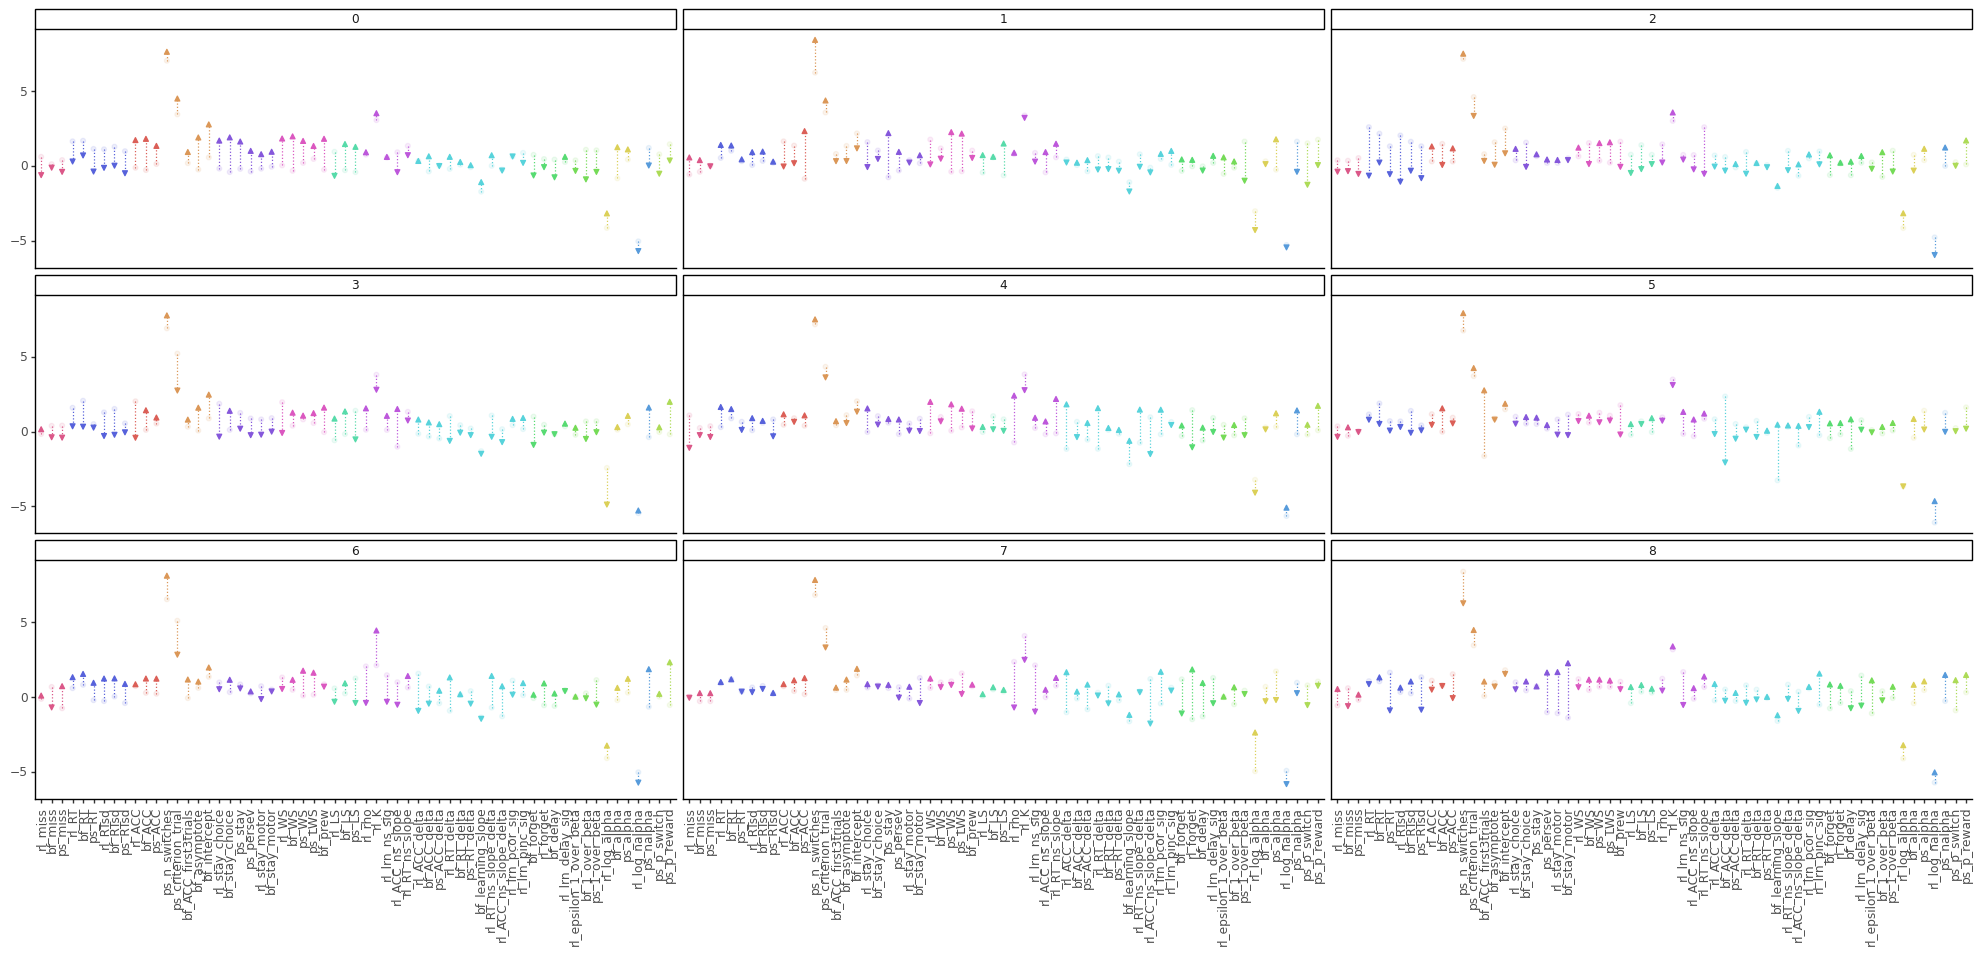

<ggplot: (135373252699)>


In [24]:
# Plot average behaviors for big (+) and small (-) values of each PC
# gg.options.figure_size = (18, 10)
gg.options.figure_size = (25, 10)
g = (gg.ggplot(feature_means_pcs_long, gg.aes('feature', 'value', color='category',
                                              shape='shape', alpha='plus_minus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='feature'), linetype='dotted', alpha=1)
     + gg.scale_shape_manual(values=('^', 'o', 'v'))
     + gg.scale_x_discrete(limits=x_ticks)
     + gg.theme(legend_position='none')
     + gg.labs(x='', y='')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
#      + gg.facet_grid('pc ~ plus_minus')
     + gg.facet_wrap('~ pc')
    )
g.save(os.path.join(plot_save_path, '3_BehaviorPlusMinus{}PCs.png'.format(feature_pc_scalar)))
print(g)

## Same for derived behaviors
e.g., RT + RT_delta; RT - RT_delta; RLWM accuracy with ns slope; etc. for PC+ and PC-

### RT early vs late

In [60]:
feature_cols = [c for c in feature_means_pcs.columns if 'feature_pc' in c]

RTs = feature_means_pcs.loc[feature_means_pcs['feature'].isin(['ps_RT', 'bf_RT', 'rl_RT']), feature_cols + ['feature']].reset_index(drop=True)
task = RTs['feature'].apply(lambda x : x[:2])
RTs = RTs.drop(columns='feature')

RT_delta = feature_means_pcs.loc[feature_means_pcs['feature'].isin(['ps_RT_delta', 'bf_RT_delta', 'rl_RT_delta']), feature_cols].reset_index(drop=True)

RT_early, RT_late = RTs + RT_delta / 2, RTs - RT_delta / 2
RT_early['feature'], RT_late['feature'] = 'RT_early', 'RT_late'
RT_early['task'], RT_late['task'] = task, task

RT_early_late = RT_early.append(RT_late)
RT_early_late

,feature_pc0+,feature_pc0-,feature_pc1+,feature_pc1-,feature_pc2+,feature_pc2-,feature_pc3+,feature_pc3-,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-,feature,task
0,1.731648,0.840740,1.303929,1.268459,2.243746,0.328642,2.280235,0.292153,0.942023,1.630365,2.242998,0.329390,0.909905,1.662483,1.576555,0.995833,1.316475,1.255913,RT_early,bf
1,1.103216,-0.345976,0.469339,0.287901,1.350089,-0.592848,0.609249,0.147992,0.586706,0.170535,0.657938,0.099302,0.006440,0.750800,0.286856,0.470384,1.624292,-0.867051,RT_early,ps
2,1.552658,0.605693,0.870394,1.287957,3.065513,-0.907163,2.114711,0.043640,-0.276548,2.434899,1.300853,0.857498,0.154190,2.004160,1.082087,1.076264,1.473158,0.685193,RT_early,rl
0,1.644234,0.568890,0.737387,1.475737,2.085894,0.127230,1.849367,0.363757,0.827052,1.386072,1.524364,0.688760,0.753037,1.460087,0.805088,1.408036,0.807300,1.405824,RT_late,bf
1,1.181537,-0.401043,0.175941,0.604553,1.288746,-0.508252,0.397427,0.383067,0.727431,0.053063,0.744421,0.036074,-0.402515,1.183009,0.501518,0.278976,1.675356,-0.894862,RT_late,ps
2,1.745800,-0.008669,0.209210,1.527922,2.127763,-0.390631,1.072611,0.664520,0.873226,0.863906,1.008239,0.728892,1.058067,0.679064,0.774284,0.962848,0.677149,1.059982,RT_late,rl


In [82]:
RT_early_late_long = RT_early_late.melt(id_vars=['feature', 'task'])
RT_early_late_long['feature'] = RT_early_late_long['feature'].apply(lambda x : x[3:])
RT_early_late_long['PC'] = RT_early_late_long['variable'].apply(lambda x : x[-2])
RT_early_late_long['PlusMinus'] = RT_early_late_long['variable'].apply(lambda x : x[-1])
RT_early_late_long

,feature,task,variable,value,PC,PlusMinus
0,early,bf,feature_pc0+,1.731648,0,+
1,early,ps,feature_pc0+,1.103216,0,+
2,early,rl,feature_pc0+,1.552658,0,+
3,late,bf,feature_pc0+,1.644234,0,+
4,late,ps,feature_pc0+,1.181537,0,+
...,...,...,...,...,...,...
103,early,ps,feature_pc8-,-0.867051,8,-
104,early,rl,feature_pc8-,0.685193,8,-
105,late,bf,feature_pc8-,1.405824,8,-
106,late,ps,feature_pc8-,-0.894862,8,-


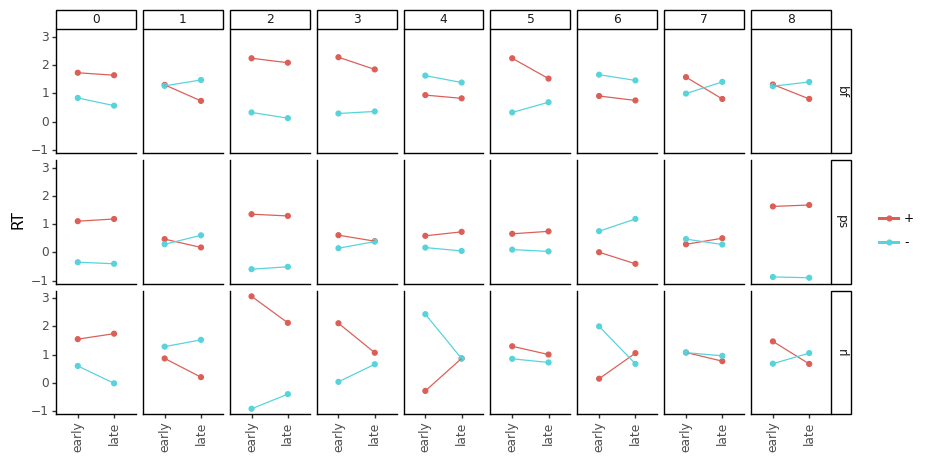

<ggplot: (135373102647)>

In [84]:
gg.options.figure_size = (10, 5)
g = (gg.ggplot(RT_early_late_long, gg.aes('feature', 'value', color='PlusMinus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='PlusMinus'))
     + gg.labs(x='', y='RT', color='')
     + gg.theme(axis_text_x=gg.element_text(rotation=90, hjust=0.5))
     + gg.facet_grid('task ~ PC')
    )
g

### RLWM accuracy with ns slope

In [108]:
RLWM_ACC = feature_means_pcs.loc[feature_means_pcs['feature'] == 'rl_ACC', feature_cols + ['feature']].reset_index(drop=True)
task = RLWM_ACC['feature'].apply(lambda x : x[:2])
RLWM_ACC = RLWM_ACC.drop(columns='feature')

RLWM_slope = feature_means_pcs.loc[feature_means_pcs['feature'] == 'rl_ACC_ns_slope', feature_cols].reset_index(drop=True)

ns_weight = {2: 1.5, 3: 0.5, 4: -0.5, 5: -1.5}
RLWM_ns = pd.DataFrame()
for ns, weight in ns_weight.items():
    RLWM_row = RLWM_ACC + weight * RLWM_slope
    RLWM_row['ns'] = ns
    RLWM_ns = RLWM_ns.append(RLWM_row)
RLWM_ns

,feature_pc0+,feature_pc0-,feature_pc1+,feature_pc1-,feature_pc2+,feature_pc2-,feature_pc3+,feature_pc3-,feature_pc4+,feature_pc4-,feature_pc5+,feature_pc5-,feature_pc6+,feature_pc6-,feature_pc7+,feature_pc7-,feature_pc8+,feature_pc8-,ns
0,1.261059,1.110360,1.009215,1.362204,1.403487,0.967932,0.512780,1.858639,0.192730,2.178689,0.707315,1.664104,2.256377,0.115042,0.739703,1.631716,0.956480,1.414939,2
0,0.341604,1.525305,1.435178,0.431730,0.671866,1.195042,1.522236,0.344672,0.369158,1.497750,1.014130,0.852779,1.249612,0.617297,0.738072,1.128836,1.058949,0.807960,3
0,-0.577852,1.940250,1.861142,-0.498744,-0.059755,1.422153,2.531693,-1.169295,0.545586,0.816812,1.320945,0.041453,0.242846,1.119552,0.736441,0.625957,1.161418,0.200980,4
0,-1.497307,2.355194,2.287105,-1.429218,-0.791375,1.649263,3.541149,-2.683261,0.722014,0.135874,1.627760,-0.769872,-0.763920,1.621807,0.734810,0.123078,1.263887,-0.405999,5


In [109]:
RLWM_ns_long = RLWM_ns.melt(id_vars='ns')
RLWM_ns_long['PlusMinus'] = RLWM_ns_long['variable'].apply(lambda x : x[-1])
RLWM_ns_long['PC'] = RLWM_ns_long['variable'].apply(lambda x : x[-2])
RLWM_ns_long['PlusMinus'] = RLWM_ns_long['variable'].apply(lambda x : x[-1])
RLWM_ns_long

,ns,variable,value,PlusMinus,PC
0,2,feature_pc0+,1.261059,+,0
1,3,feature_pc0+,0.341604,+,0
2,4,feature_pc0+,-0.577852,+,0
3,5,feature_pc0+,-1.497307,+,0
4,2,feature_pc0-,1.110360,-,0
...,...,...,...,...,...
67,5,feature_pc8+,1.263887,+,8
68,2,feature_pc8-,1.414939,-,8
69,3,feature_pc8-,0.807960,-,8
70,4,feature_pc8-,0.200980,-,8


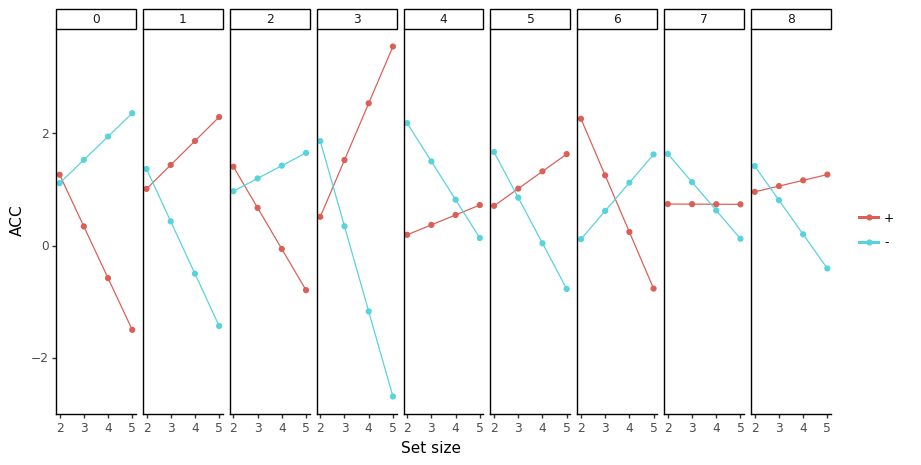

<ggplot: (135372603889)>

In [111]:
g = (gg.ggplot(RLWM_ns_long, gg.aes('ns', 'value', color='PlusMinus'))
     + gg.geom_point()
     + gg.geom_line(gg.aes(group='PlusMinus'))
     + gg.labs(x='Set size', y='ACC', color='')
     + gg.facet_grid('~ PC')
    )
g